In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

import numpy as np

from testcases import TestCase

from domains import Waveguide, ScattererShape, ScattererType

# Sandbox

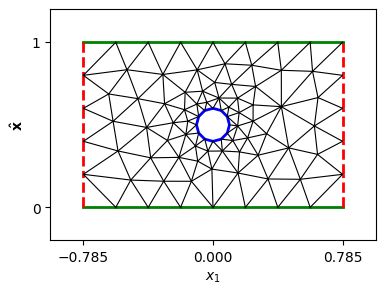

In [2]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
c = (-0.2*R,0.1*H)
half_infinite = True
#Domain = Waveguide(R=2*R,H=H, half_infinite=half_infinite)
Domain = Waveguide(R=R,H=H)
Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, ((0,0.5*H), 0.1*H))
Domain.generate_mesh(h_max=H/5)
Domain.plot_mesh()

In [3]:
from exact_solutions import GreenFunctionImages, GreenFunctionModes

Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

M = 400

u_modes = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., 0.5*H, M=M), (Ny,Nx))
u_images = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., 0.5*H, M=M), (Ny,Nx))


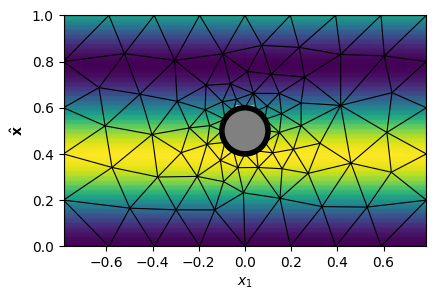

In [4]:
Domain.plot_field(X,Y,np.real(u_images-u_modes), show_edges=True)

-0.0015739442152253869

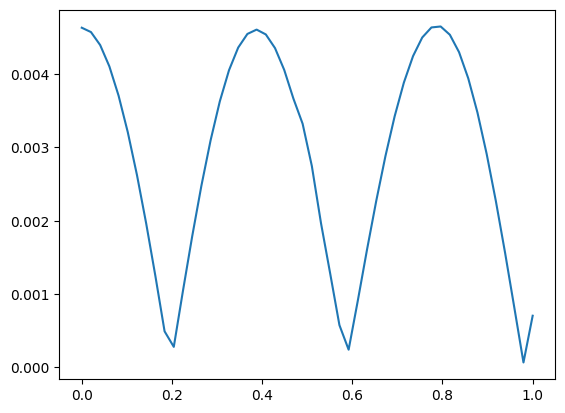

In [5]:
j = 249
plt.plot(y,np.abs(u_images-u_modes)[:,j])
x[j]

In [6]:
from Trefft_tools import  TrefftzSpace
Nth = 1
th_0 = np.e/np.pi # no correct direction in the basis
#th_0= 0. # right direction in the basis
V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )


In [7]:
from Trefft_tools import AssembleMatrix
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

148 degrees of freedom.
 Matrix with 594 non-zero entries from a total of 21904.
 "fullness" ratio:  2.71%


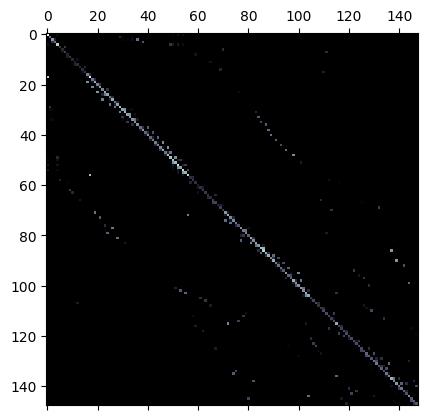

In [8]:
from checking_tools import plot_sparsity
plot_sparsity(A)

In [9]:
# Ncond = np.linalg.cond(A.toarray())
# Ncond

In [10]:
from Trefft_tools import AssembleGreenRHS, AssembleRHS
from exact_solutions import GreenFunctionModes, GreenFunctionImages

In [11]:
B = AssembleGreenRHS(V, Domain.Edges, kappa_e, H, a=a, x_0 = c[0], y_0=c[1], modes=True)
# t = 1
# B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

In [12]:
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

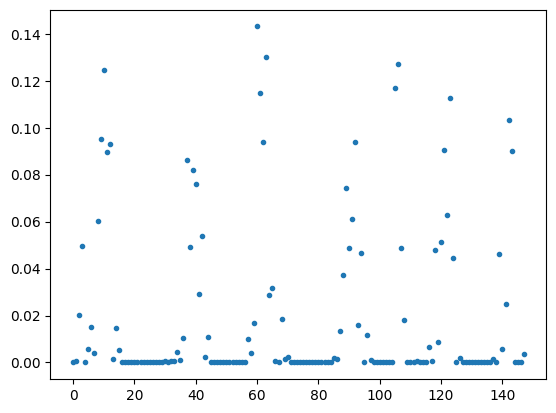

In [13]:
plt.plot(np.abs(DOFs),'.')

In [14]:
Ny = 50
Nx = 10*Ny
if half_infinite:
    x = np.linspace(0,2*R,Nx)
else:
    x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=100), (Ny,Nx))
# u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=80), (Ny,Nx))
# u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)

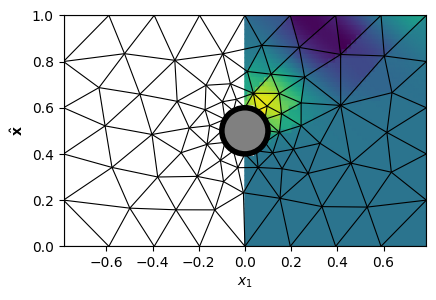

In [15]:

Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)

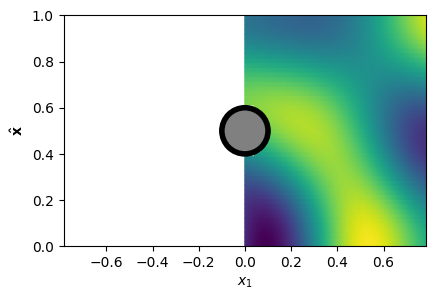

In [16]:
Domain.plot_field(X,Y,np.real(u_exact))

Text(0.5, 0.98, '$L_2$ error:  nan %')

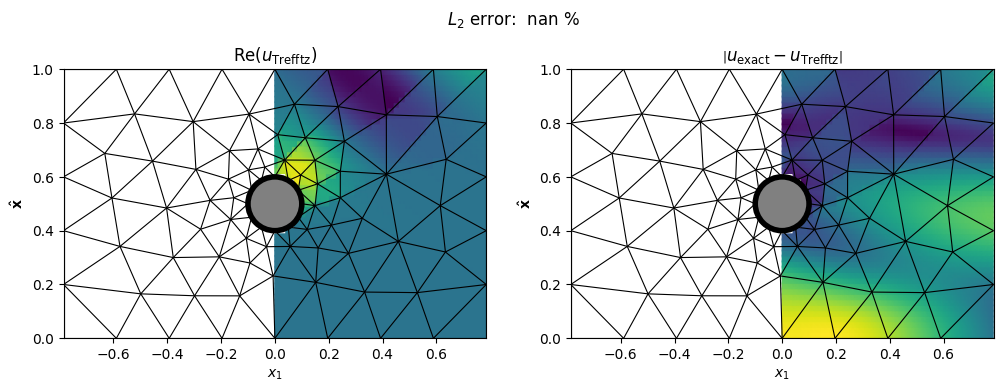

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
Domain.plot_field(X,Y,np.real(u_Trefft),ax=ax[0], show_edges=True)
Domain.plot_field( X,Y,np.abs(u_Trefft-u_exact),ax=ax[1], show_edges=True)
ax[0].set_title('$\\mathrm{Re}(u_\\mathrm{Trefftz})$')
ax[1].set_title('$\\left|u_\\mathrm{exact}-u_\\mathrm{Trefftz}\\right|$')

fig.suptitle(f'$L_2$ error: {Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 : .2e} %')

#plt.savefig(f'error_circle_k_{kappa_e:.3f}.png')

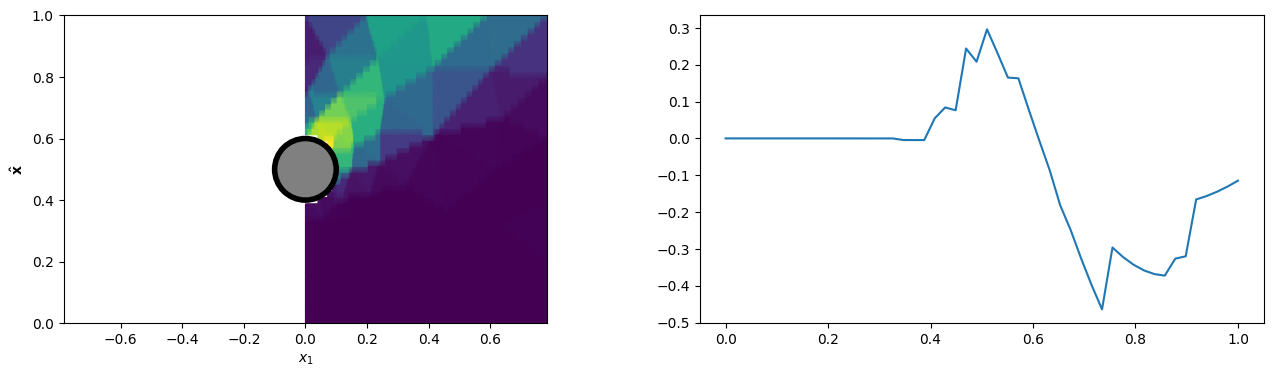

In [18]:
du_Trefft_dy =  np.reshape([ f.dy(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
fig, ax = plt.subplots(ncols=2,figsize=(16,4))
Domain.plot_field(X,Y,np.abs(du_Trefft_dy), ax=ax[0])
ax[1].plot(y,np.real(du_Trefft_dy)[:,36])

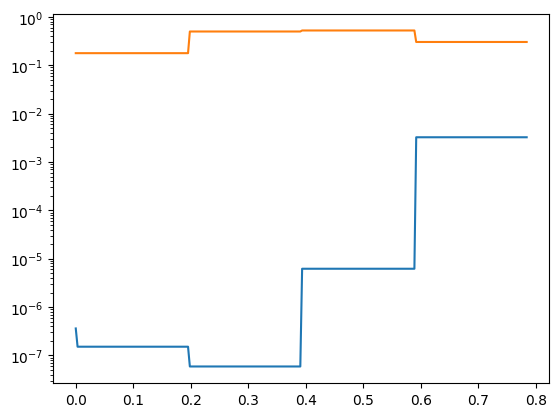

In [19]:
plt.semilogy(x,np.abs(du_Trefft_dy[0,:]))
plt.semilogy(x,np.abs(du_Trefft_dy[-1,:]))
# plt.plot(x,np.real(du_Trefft_dy[0,:]))
# plt.plot(x,np.real(du_Trefft_dy[-1,:]))

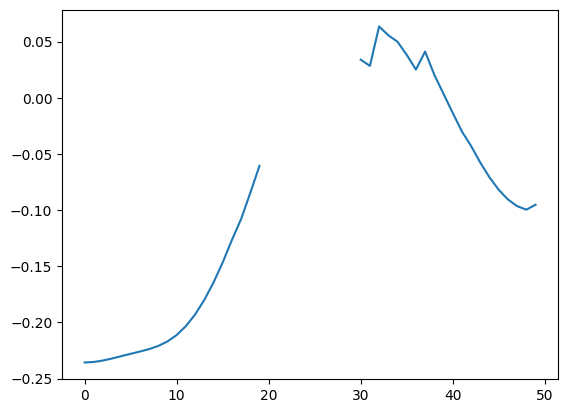

In [20]:
plt.plot(np.real(u_exact - u_Trefft)[:,0])

# Projection

In [24]:
def integrate_ref(f,N=100):
    t = np.linspace(0,1,N+1)
    tx, ty = np.meshgrid(t,t)
    z = np.ma.array(f(tx,ty),mask=(tx+ty>1)) 
    # tx = np.ma.array( tx, )
    # ty = np.ma.array( ty, mask=(tx+ty>1))
    return z.sum()*(1/N*1/N)

integrate_ref(lambda x, y : x**2,2000)
#integrate_ref(lambda x, y : np.ones_like(x),2000)



0.08350010418750006

In [34]:
def fek3_int(f, r_A=(0,0), r_B=(1,0), r_C=(0,1)):
    ABx = r_B[0] - r_A[0]
    ABy = r_B[1] - r_A[1]
    ACx = r_C[0] - r_A[0]
    ACy = r_C[1] - r_A[1]
    S = 0.5 * (ABx*ACy - ABy*ACx)
    J = S/2.
    points = np.array([[1./3, 1./3, 1./3],
                    [0., 0., 1.],
                    [0., 1., 0.],
                    [1., 0., 0.],
                    [0., 0.2763932023, 0.7236067977],
                    [0.7236067977, 0.2763932023, 0.],
                    [0.7236067977, 0., 0.2763932023],
                    [0., 0.7236067977, 0.2763932023],
                    [0.2763932023, 0.7236067977, 0.],
                    [0.2763932023, 0., 0.7236067977]]) 
    
    x = r_A[0]*points[:,0] + r_B[0]*points[:,1] + r_C[0]*points[:,2]
    y = r_A[1]*points[:,0] + r_B[1]*points[:,1] + r_C[1]*points[:,2]
    
    w = np.array([ 0.9, 0.1/3, 0.1/3, 0.1/3, 1./6, 1./6, 1./6, 1./6, 1./6, 1./6 ])
    z = f(x,y)
    I = np.sum(z*w)
    return J*I 

# fek3_int(lambda x, y : np.ones_like(x), r_B=(1,0), r_C=(0,1))
# fek3_int(lambda x, y : x**2)


0.08333333332960813

## Proyection of a mode

at each triangle, the basis

$$
\left\{\varphi_n(\mathbf{x}) = e^{ik\mathbf{d}_n \cdot\mathbf{x}}\right\}_{n=1}^{N_p}
$$
is not orthogonal.
$$
u = \sum_{n=1}^{N_p} u_n \varphi_n
$$
so
$$
\sum_{n=1}^{N_p}\left\langle \varphi_n,\varphi_m\right\rangle u_n = \left\langle u_\mathrm{mode},\varphi_m \right\rangle\quad m=1,2,\dots, N_p
$$

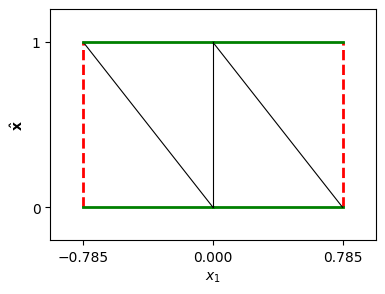

In [104]:
Domain = Waveguide(R=R,H=H)
Domain.generate_mesh(h_max=H) 
Omega = Domain.Omega
Domain.plot_mesh()


In [123]:
r_A, r_B, r_C = [ Omega.vertices[v.nr].point for v in Omega.faces[0].vertices ] 

Nth = 7

t = 2
beta = np.emath.sqrt(kappa_e**2 - (np.pi*t/H)**2)



d_s = np.array( [[np.cos(th), np.sin(th)] for th in np.linspace(0,2*np.pi,Nth,endpoint=False)])
G = np.zeros( (Nth,Nth), dtype=np.complex128)
F = np.zeros(Nth,dtype=np.complex128)

for n in range(Nth):
    d_n = d_s[n]
    for m in range(Nth):
        d_m = d_s[m]
        G[m,n] = fek3_int( lambda x, y : np.exp(1j*kappa_e*((d_n - d_m)[0]*x + (d_n - d_m)[1]*y)), r_A=r_A, r_B=r_B, r_C=r_C)
        F[m] = fek3_int( lambda x, y : np.exp(1j*(beta - kappa_e*d_m)[0]*x)*np.exp(-1j*kappa_e*d_m[1]*y)*np.cos(t*np.pi*y/H), r_A=r_A, r_B=r_B, r_C=r_C) 

In [124]:
coef_proy = np.linalg.solve(G,F)

x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)


u_proy = sum( [coef_proy[n]*np.exp(1j*kappa_e*(d_s[n][0]*X + d_s[n][1]*Y)) for n in range(Nth)])

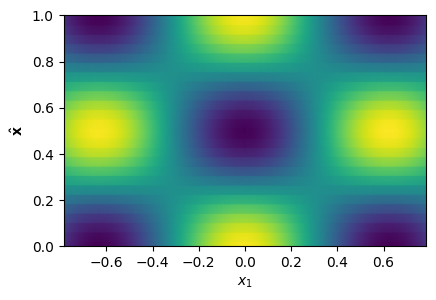

In [125]:
Domain.plot_field(X,Y,np.real(u_proy))

In [52]:
Omega = Domain.Omega

## condition number estimator: 

In [35]:
from scipy.sparse.linalg import svds
from scipy.sparse import sparray
def cond(A : sparray)-> np.float64:
    max_iter = 40000
    S_max = svds(A,k=1,which="LM", maxiter=max_iter, solver='lobpcg', return_singular_vectors=False)[0]
    S_min = svds(A,k=1,which="SM", maxiter=max_iter, solver='lobpcg',return_singular_vectors=False)[0]
    return S_max, S_min, S_max / S_min


# Convergence

In [30]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 8/8

kappa_e = factor*8.
lambda_e = 2*np.pi/kappa_e
R = factor*lambda_e
H = 1.


half_infinite = False
#c = (-0.6*H,0.6*H)
c = (0,0.6*H)

t=1

Ny = 100
Nx = int(R/H*Ny)
if half_infinite:
    x = np.linspace(0,2*R,Nx)
else:
    x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

M = 3200
modes = True
if modes:
    u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))
else:
    u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))


# t = 1
# u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)
for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/(N)
    hs[i] = h
    #Domain = Waveguide(R=2*R,H=H, half_infinite=half_infinite) # CHANGE THIS
    Domain = Waveguide(R=R,H=H) 
    Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
    #Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.SOUND_SOFT, (c, 0.2*H, 0.2*H))
    # Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.SOUND_SOFT, ((R,0.6*H), 0.2*H, 0.2*H))
    
    # Domain.add_fine_mesh_region(h_min=0.01*H)
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    print(f'{h_max=}')


    for (j,Nth) in enumerate(N_ths):
        # plt.close()
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        # a = a*h_max/side_ls
        # b = b*h_max/side_ls
        # d_1 = d_1*h_max/side_ls
        # d_2 = d_2*h_max/side_ls


        A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
        _, _, conds[i,j] = cond(A)
        #conds.append(np.linalg.cond(A.toarray()))
        B = AssembleGreenRHS(V, Domain.Edges, kappa_e, Domain.H, a=a, x_0=c[0], y_0=c[1], modes=modes, M=M)
        #B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

        A = A.tocsc()
        
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])

        
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 
        # Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)



    
    

working on refinement: N=3
h_max=0.4223385685436916
N_theta=3...
N_theta=5...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[2.09920514e-05]
not reaching the requested tolerance 9.08970832824707e-06.
Use iteration 38034 instead with accuracy 
1.0458373972300236e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.0458374e-05]
not reaching the requested tolerance 9.08970832824707e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=0.38900205060513837
N_theta=3...
N_theta=5...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[7.72275593e-05]
not reaching the requested tolerance 9.611248970031738e-06.
Use iteration 34636 instead with accuracy 
2.7058004130258453e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[2.70580027e-05]
not reaching the requested tolerance 9.611248970031738e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=5
h_max=0.28027333478544764
N_theta=3...
N_theta=5...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[2.56355945e-05]
not reaching the requested tolerance 1.1324882507324219e-05.
Use iteration 38785 instead with accuracy 
1.4742562247150881e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.47425623e-05]
not reaching the requested tolerance 1.1324882507324219e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=0.2511462607299692
N_theta=3...
N_theta=5...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[3.69077836e-05]
not reaching the requested tolerance 1.385807991027832e-05.
Use iteration 38968 instead with accuracy 
1.994407450353169e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.99440708e-05]
not reaching the requested tolerance 1.385807991027832e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=0.2019898707748881
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=0.1803798998483503
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max=0.1591277412982581
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...


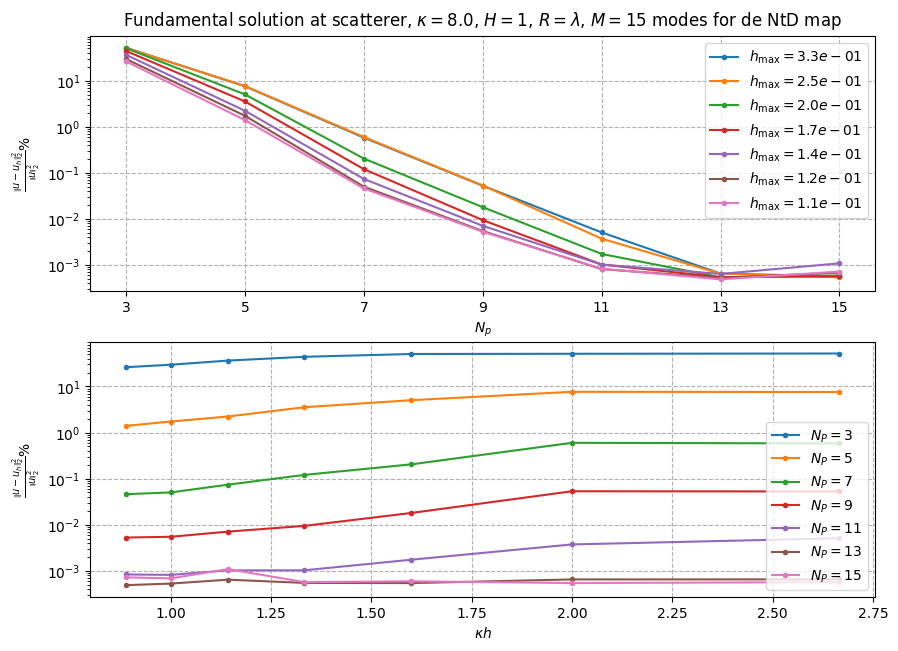

In [33]:
inches_per_dot = 1/72.27
cm2inch = 1/2.54 # inch per cm
columnwidth = 630.185 * inches_per_dot
#columnwidth = 524.07272*inches_per_dot

columnwidth=columnwidth*0.9

left_margin = 1. * cm2inch # cm
right_margin = 1.*cm2inch  # cm
figure_width = columnwidth # cm
figure_height = columnwidth/1.4 # cm
top_margin = 1.*cm2inch    # cm
bottom_margin = 1.*cm2inch # cm

box_width = left_margin + figure_width + right_margin   # cm
box_height = top_margin + figure_height + bottom_margin # cm


# specifying the width and the height of the box in inches
# fig = plt.figure(figsize=(box_width,box_height))
# ax = fig.add_subplot(111)

fig, ax = plt.subplots(nrows=2,figsize=(box_width,box_height))

for err, h in zip(errors,hs):
    ax[0].semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')



fig.suptitle(f'Fundamental solution at scatterer, $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD map')

ax[0].set_xlabel('$N_p$')
ax[0].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[0].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[0].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax[0].set_xticks(range(3,17,2))
ax[0].grid(True,which="major",ls='--')
ax[0].legend()


for err, N_th in zip(errors.transpose(),N_ths):
    ax[1].semilogy(kappa_e*hs,err,'.-', label=f'$N_P = {N_th}$')

ax[1].set_xlabel('$\\kappa h$')
ax[1].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[1].legend(loc="lower right")
ax[1].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[1].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')




fig.subplots_adjust(left   = left_margin / box_width,
                    bottom = bottom_margin / box_height,
                    right  = 1. - right_margin / box_width,
                    top    = 1. - top_margin   / box_height)


#plt.text(x=11,y=1E-7,s='$\\propto 2^{-2.5p}$')
#plt.savefig('p-convergence_mode_1_reescaling.png')
plt.savefig(f'convergence_fundamental.pdf')


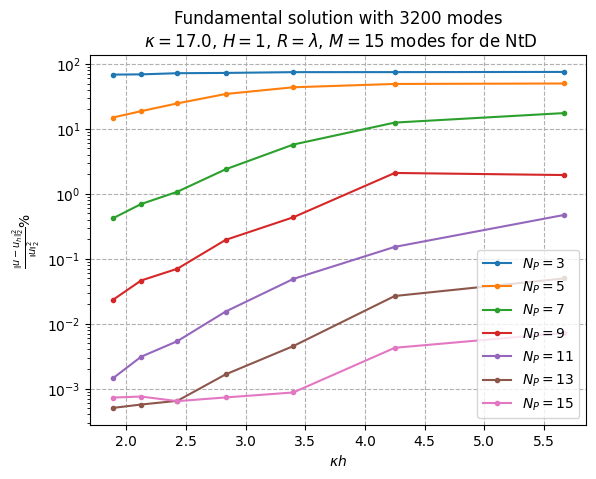

In [59]:

for err, N_th in zip(errors.transpose(),N_ths):
    plt.semilogy(kappa_e*hs,err,'.-', label=f'$N_P = {N_th}$')

#plt.title(f'Propataging mode {t},\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
#plt.title(f'Half waveguide,\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
plt.title(f'Fundamental solution with {M} modes\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')

#plt.xlabel('$\\frac{1}{\\kappa h}$')
plt.xlabel('$\\kappa h$')
plt.ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')
plt.savefig(f'h-convergence_circle_k_{kappa_e:.3f}.png')

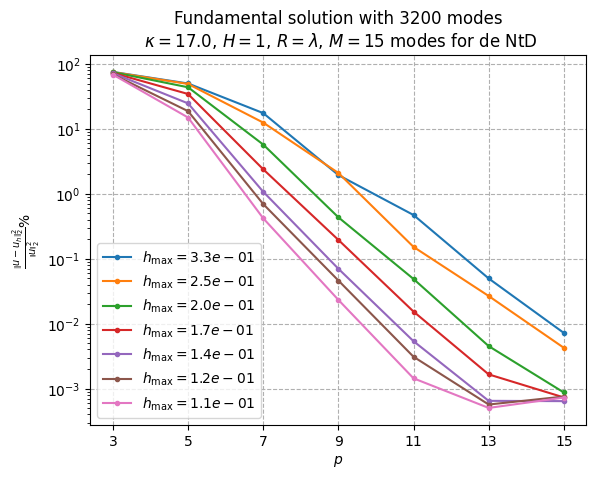

In [60]:
for err, h in zip(errors,hs):
    plt.semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')



#plt.title(f'Half waveguide,\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
#plt.title(f'Propataging mode {t},\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
plt.title(f'Fundamental solution with {M} modes\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')

plt.xlabel('$p$')
plt.ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
plt.xticks(range(3,17,2))
plt.grid(True,which="major",ls='--')
plt.legend()
#plt.text(x=11,y=1E-7,s='$\\propto 2^{-2.5p}$')
#plt.savefig('p-convergence_mode_1_reescaling.png')
plt.savefig(f'p-convergence_circle_k_{kappa_e:.3f}.png')


In [ ]:
# conds = []
# refinements = range(3,10,1)
# N_ths = [3,5,7,9,11,13,15]


# N_ref = len(refinements)
# N_N_th = len(N_ths)

# hs = np.zeros((N_ref), dtype=np.float64)
# errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

# factor = 8

# kappa_e = factor*8.
# lambda_e = 2*np.pi/kappa_e
# R = factor*lambda_e
# H = 1.


# half_infinite = False
# #c = (-0.6*H,0.6*H)
# c = (0,0.6*H)

# t=1

# Ny = 100
# Nx = int(R/H*Ny)
# if half_infinite:
#     x = np.linspace(0,2*R,Nx)
# else:
#     x = np.linspace(-R,R,Nx)
# y = np.linspace(0,H,Ny)
# X, Y = np.meshgrid(x,y)

# M = 3200
# modes = True
# if modes:
#     u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))
# else:
#     u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))


# # t = 1
# # u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)
# for (i,N) in enumerate(refinements):
#     print(f"working on refinement: {N=}")
#     h = H/(N)
#     hs[i] = h
#     #Domain = Waveguide(R=2*R,H=H, half_infinite=half_infinite) # CHANGE THIS
#     Domain = Waveguide(R=R,H=H) 
#     Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
#     #Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.SOUND_SOFT, (c, 0.2*H, 0.2*H))
#     # Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.SOUND_SOFT, ((R,0.6*H), 0.2*H, 0.2*H))
    
#     # Domain.add_fine_mesh_region(h_min=0.01*H)
#     Domain.generate_mesh(h_max=h)

#     side_ls = np.array([E.l for E in Domain.Edges])
#     h_max = np.max(side_ls)
#     print(f'{h_max=}')


#     for (j,Nth) in enumerate(N_ths):
#         # plt.close()
#         print(f"N_theta={Nth}...")
#         th_0 = np.e/np.pi # no correct direction in the basis
#         V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
#         N_modes = 15 #Number of modes for the DtN map
#         # "UWVF" parameters
#         a = 0.5
#         b = 0.5
#         d_1 = 0.5
#         d_2 = 0.5



#         A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
#         #conds.append(np.linalg.cond(A.toarray()))
#         B = AssembleGreenRHS(V, Domain.Edges, kappa_e, Domain.H, a=a, x_0=c[0], y_0=c[1], modes=modes, M=M)
#         #B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

#         A = A.tocsc()
#         DOFs = spsolve(A,B)
#         f = TrefftzFunction(V,DOFs)

#         u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])

        
#         errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 
#         # Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)



In [23]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 8/8

kappa_e = factor*8.
lambda_e = 2*np.pi/kappa_e
R = factor*lambda_e
H = 1.


c = (0,0.6*H)

t=1

Ny = 100
Nx = int(R/H*Ny)
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)



t = 1
u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)

for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/(N)
    hs[i] = h
    Domain = Waveguide(R=R,H=H) 
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    print(f'{h_max=}')


    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5



        A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
        _,_, conds[i,j] = cond(A)
        B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

        A = A.tocsc()
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])

        
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 
        


    
    

working on refinement: N=3
h_max=0.4580471101557189
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[6.28979301e-05]
not reaching the requested tolerance 4.023313522338867e-06.
Use iteration 39624 instead with accuracy 
1.838935817848076e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.83893964e-05]
not reaching the requested tolerance 4.023313522338867e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=0.36199298260050544
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[4.83853084e-05]
not reaching the requested tolerance 6.973743438720703e-06.
Use iteration 39339 instead with accuracy 
2.219685804090279e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[2.21968578e-05]
not reaching the requested tolerance 6.973743438720703e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=11...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[7.09423681e-05]
not reaching the requested tolerance 8.52346420288086e-06.
Use iteration 38274 instead with accuracy 
1.852672912632715e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.85267287e-05]
not reaching the requested tolerance 8.52346420288086e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=13...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[7.40002662e-05]
not reaching the requested tolerance 1.0073184967041016e-05.
Use iteration 37823 instead with accuracy 
1.883346681189983e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.88334656e-05]
not reaching the requested tolerance 1.0073184967041016e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=15...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[7.06076481e-05]
not reaching the requested tolerance 1.1622905731201172e-05.
Use iteration 37023 instead with accuracy 
2.3354113771659384e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[2.33541147e-05]
not reaching the requested tolerance 1.1622905731201172e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


working on refinement: N=5
h_max=0.28998965946483024
N_theta=3...
N_theta=5...
N_theta=7...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[7.33528849e-05]
not reaching the requested tolerance 9.804964065551758e-06.
Use iteration 39548 instead with accuracy 
1.8137029302274768e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.8137018e-05]
not reaching the requested tolerance 9.804964065551758e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=0.24691193897502972
N_theta=3...
N_theta=5...
N_theta=7...


/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 40000 with accuracies 
[3.87932084e-05]
not reaching the requested tolerance 1.2934207916259766e-05.
Use iteration 39458 instead with accuracy 
1.7027146724102572e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/manuel/.local/share/virtualenvs/UWVFTrefftz--hy3v2Qt/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.70271468e-05]
not reaching the requested tolerance 1.2934207916259766e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=0.2052507504617864
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=0.1773973634113433
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max=0.16158061930260545
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...


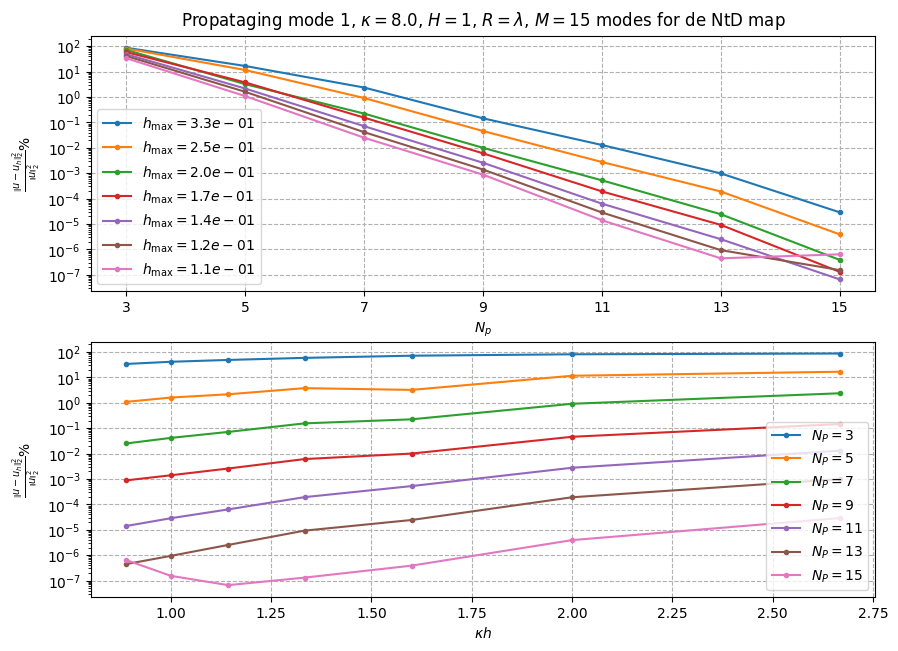

In [27]:
inches_per_dot = 1/72.27
cm2inch = 1/2.54 # inch per cm
columnwidth = 630.185 * inches_per_dot
#columnwidth = 524.07272*inches_per_dot

columnwidth=columnwidth*0.9

left_margin = 1. * cm2inch # cm
right_margin = 1.*cm2inch  # cm
figure_width = columnwidth # cm
figure_height = columnwidth/1.4 # cm
top_margin = 1.*cm2inch    # cm
bottom_margin = 1.*cm2inch # cm

box_width = left_margin + figure_width + right_margin   # cm
box_height = top_margin + figure_height + bottom_margin # cm


# specifying the width and the height of the box in inches
# fig = plt.figure(figsize=(box_width,box_height))
# ax = fig.add_subplot(111)

fig, ax = plt.subplots(nrows=2,figsize=(box_width,box_height))

for err, h in zip(errors,hs):
    ax[0].semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')



fig.suptitle(f'Propataging mode {t}, $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD map')

ax[0].set_xlabel('$N_p$')
ax[0].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[0].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[0].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax[0].set_xticks(range(3,17,2))
ax[0].grid(True,which="major",ls='--')
ax[0].legend()


for err, N_th in zip(errors.transpose(),N_ths):
    ax[1].semilogy(kappa_e*hs,err,'.-', label=f'$N_P = {N_th}$')

ax[1].set_xlabel('$\\kappa h$')
ax[1].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[1].legend(loc="lower right")
ax[1].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[1].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')




fig.subplots_adjust(left   = left_margin / box_width,
                    bottom = bottom_margin / box_height,
                    right  = 1. - right_margin / box_width,
                    top    = 1. - top_margin   / box_height)


#plt.text(x=11,y=1E-7,s='$\\propto 2^{-2.5p}$')
#plt.savefig('p-convergence_mode_1_reescaling.png')
plt.savefig(f'convergence.pdf')


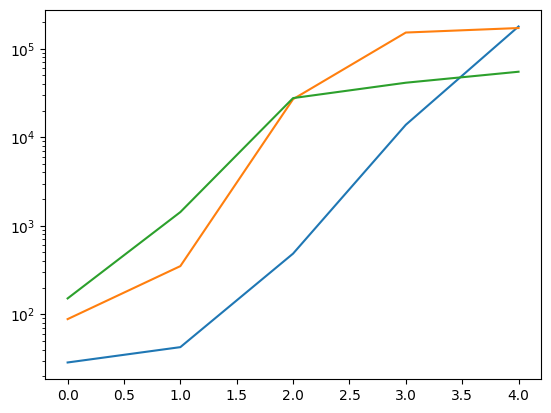

In [49]:
plt.semilogy(conds[0,:])
plt.semilogy(conds[1,:])
plt.semilogy(conds[2,:])

In [46]:
conds.shape

(3, 5)